In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import ujipenchars2
from preprocessing import DrawingToBoxScaler, DrawingResampler
from dtw import dtw_distance_matrix_symmetric, rsi_dtw_distance_matrix_symmetric
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from classifier_pickle import SVMDTWPickle, SVMRSIDTWPickle

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

len(train), len(test)

(800, 400)

In [3]:
# Preprocessing
drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

drawing_resampler = DrawingResampler(50)
data = drawing_resampler.transform(data)

# Tenzor sa svim podacima
stacked_data = np.stack([np.vstack(drawing.strokes) for drawing in data])

# SVM: DTW

In [4]:
# Matrica s DTW udaljenostima
DTW = dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx])

In [5]:
class GridSearchGamma:
    def __init__(self, estimator, gammas, param_grid, cv=5):
        self.gammas = gammas
        self.best_score_ = 0
        self.best_index_ = 0
        self.best_gamma_ = None
        self.best_params_ = None
        self.best_estimator_ = None
        
        self.gs = [GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1, cv=cv) for gamma in gammas]

    @staticmethod
    def kernel_transform(X, gamma):
        return np.exp(-gamma * X)

    def fit(self, X, y):
        for i in range(len(self.gammas)):
            self.gs[i].fit(GridSearchGamma.kernel_transform(X, self.gammas[i]), y)
            if self.gs[i].best_score_ > self.best_score_:
                self.best_index_ = i
                self.best_score_ = self.gs[i].best_score_
        self.best_gamma_ = self.gammas[self.best_index_]
        self.best_params_ = self.gs[self.best_index_].best_params_
        self.best_estimator_ = self.gs[self.best_index_].best_estimator_

    def score(self, X, y):
        return self.gs[self.best_index_].score(GridSearchGamma.kernel_transform(X, self.best_gamma_), y)


gs = GridSearchGamma(
    estimator = SVC(kernel='precomputed'),
    gammas = np.arange(0.4, 0.7, 0.02),
    param_grid = {'C': np.arange(0.5, 0.9, 0.02)},
)

np.random.seed(0)
gs.fit(DTW[np.ix_(train_idx, train_idx)], labels[train_idx])

In [6]:
print('Najbolji parametri:', ', '.join(f'{k} = {v:.4g}' for k, v in ({'gamma': gs.best_gamma_} | gs.best_params_).items()))
print('Najbolja CV točnost:', gs.best_score_)
print('Točnost na test skupu:', gs.score(DTW[np.ix_(test_idx, train_idx)], labels[test_idx]))
print('\nBroj potpornih vektora:', len(gs.best_estimator_.support_))

Najbolji parametri: gamma = 0.52, C = 0.62
Najbolja CV točnost: 0.975
Točnost na test skupu: 0.9775

Broj potpornih vektora: 320


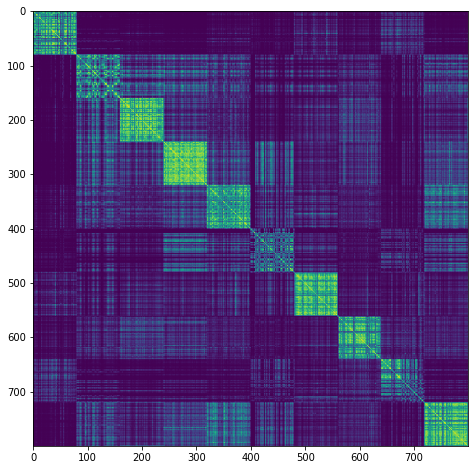

In [7]:
# Plot kernel funkcije na train podacima za najbolji gamma
sorted_idx = np.argsort(labels[train_idx])
plt.figure(figsize=(8, 8))
plt.imshow(gs.kernel_transform(DTW[np.ix_(sorted_idx, sorted_idx)], gs.best_gamma_), cmap='viridis')
plt.show()

In [8]:
# Spremamo najbolji DTW model:
SVMDTWPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=gs.best_estimator_,
    gamma=gs.best_gamma_,
).save('models/SVM-DTW.pickle')

# SVM: RSIDTW

In [9]:
# Matrica s RSIDTW udaljenostima
RSIDTW = rsi_dtw_distance_matrix_symmetric(stacked_data, stacked_data[train_idx], 10)

In [10]:
gs = GridSearchGamma(
    estimator = SVC(kernel='precomputed'),
    gammas = np.arange(1, 1.3, 0.02),
    param_grid = {'C': np.arange(0.5, 1, 0.02)},
)

np.random.seed(0)
gs.fit(RSIDTW[np.ix_(train_idx, train_idx)], labels[train_idx])

print('Najbolji parametri:', ', '.join(f'{k} = {v:.4g}' for k, v in ({'gamma': gs.best_gamma_} | gs.best_params_).items()))
print('Najbolja CV točnost:', gs.best_score_)
print('Točnost na test skupu:', gs.score(RSIDTW[np.ix_(test_idx, train_idx)], labels[test_idx]))
print('\nBroj potpornih vektora:', len(gs.best_estimator_.support_))

Najbolji parametri: gamma = 1.02, C = 0.8
Najbolja CV točnost: 0.9662499999999999
Točnost na test skupu: 0.9775

Broj potpornih vektora: 329


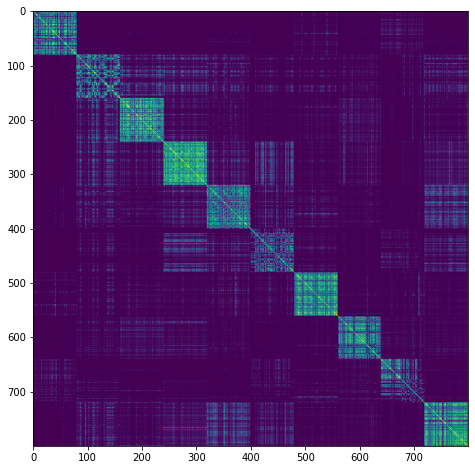

In [11]:
# Plot kernel funkcije na train podacima za najbolji gamma
sorted_idx = np.argsort(labels[train_idx])
plt.figure(figsize=(8, 8))
plt.imshow(gs.kernel_transform(DTW[np.ix_(sorted_idx, sorted_idx)], gs.best_gamma_), cmap='viridis')
plt.show()

In [12]:
# Spremamo najbolji RSIDTW model:
SVMRSIDTWPickle(
    stacked_train=stacked_data[train_idx],
    drawing_scaler=drawing_scaler,
    drawing_resampler=drawing_resampler,
    cls=gs.best_estimator_,
    n_iter=10,
    gamma=gs.best_gamma_,
).save('models/SVM-RSIDTW.pickle')